In [0]:
from google.colab import files
import os
import glob
def get_data(dataset_api):
  files.upload()
  os.system('mkdir ~/.kaggle')
  os.system('cp kaggle.json ~/.kaggle/')
  os.system('chmod 600 ~/.kaggle/kaggle.json')
  os.system(dataset_api)
  os.system('mkdir dataset_dir')

  list_of_files = glob.glob('*.zip') # * means all if need specific format then *.csv
  latest_file = max(list_of_files, key=os.path.getctime)
  print(latest_file)
  cmd='unzip '+latest_file +' -d ' + latest_file[:-4]
  #unzip natural-images.zip -d natural_images
  os.system(cmd)

In [0]:
get_data('kaggle datasets download -d prasunroy/natural-images')

Saving kaggle.json to kaggle.json
natural-images.zip


In [0]:
import cv2
from tqdm.notebook import tqdm
x=[]
z=[]
img_size=150
AIRPLANE_DIR='/content/natural-images/natural_images/airplane'
CAR_DIR='/content/natural-images/natural_images/car'
CAT_DIR='/content/natural-images/natural_images/cat'
DOG_DIR='/content/natural-images/natural_images/dog'
FLOWER_DIR='/content/natural-images/natural_images/flower'
FRUIT_DIR='/content/natural-images/natural_images/fruit'
MOTORBIKE_DIR='/content/natural-images/natural_images/motorbike'
PERSON_DIR='/content/natural-images/natural_images/person'

def assign_label(img,type):
  return type
def make_train_data(type,dir):
  for img in tqdm(os.listdir(dir)):
    label=assign_label(img,type)
    path=os.path.join(dir,img)
    img=cv2.imread(path,cv2.IMREAD_COLOR)
    img=cv2.resize(img,(img_size,img_size))
    x.append(img)
    z.append(label)

In [0]:
make_train_data('airplane',AIRPLANE_DIR)
print(len(x))

make_train_data('car',CAR_DIR)
print(len(x))

make_train_data('cat',CAT_DIR)
print(len(x))

make_train_data('dog',DOG_DIR)
print(len(x))

make_train_data('flower',FLOWER_DIR)
print(len(x))

make_train_data('fruit',FRUIT_DIR)
print(len(x))

make_train_data('motorbike',MOTORBIKE_DIR)
print(len(x))

make_train_data('person',PERSON_DIR)
print(len(x))


727



1695



2580



3282



4125



5125



5913



6899


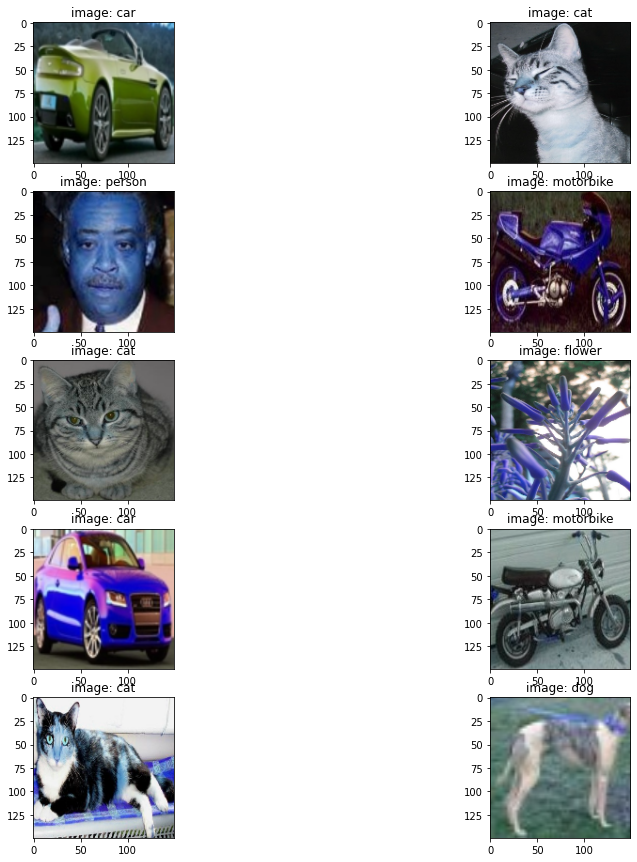

In [0]:
#Visualize some images from dataset
import matplotlib.pyplot as plt
import random as rn
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
  for j in range(2):
    l=rn.randint(0,len(z))
    ax[i,j].imshow(x[l])
    ax[i,j].set_title('image: '+z[l])

In [0]:
#Label Encoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(z)
print(y)
print(type(x))

[0 0 0 ... 7 7 7]
<class 'list'>


In [0]:
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.preprocessing import OneHotEncoder 
y=to_categorical(y)
print(y)
x=np.array(x)


Using TensorFlow backend.


[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [0]:
#split data into training and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)
np.random.seed(42)
rn.seed(42)

In [0]:
#Lets do some data augmentation magic
from keras.preprocessing.image import ImageDataGenerator
batch_size=16
train_datagen=ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip='True',vertical_flip='False',rotation_range=30,rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)


train_datagen.fit(x_train)
train_data=train_datagen.flow(x_train,y_train,batch_size=batch_size)

test_datagen.fit(x_test)
test_data=test_datagen.flow(x_test,y_test,batch_size=batch_size)

In [0]:
#Design our model from scratch
from keras.models import Sequential,Model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, Activation

In [0]:
model=Sequential()
model.add(Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(8,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10368)            

In [0]:
#Let's make transfer learning model
def build_finetune_model(base_model,dropout,fc_layers,num_classes):
  for layer in base_model.layers:
    layer.trainable=False

  x=base_model.output

  x=Flatten()(x)
  for fc in fc_layers:
    x=Dense(fc,activation='relu')(x)
    x=Dropout(dropout)(x)

  prediction=Dense(num_classes,activation='softmax')(x)

  finetune_model=Model(inputs=base_model.input,outputs=prediction)
  return finetune_model
  


In [0]:
from keras.applications.resnet50 import ResNet50
height,width=150,150
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(height,width,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
dropout=0.4
fc_layers=[1024,1024]
num_classes=8
finetune_model=build_finetune_model(base_model,dropout=dropout,fc_layers=fc_layers,num_classes=num_classes)
finetune_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
#Let's compile both models
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

adam=Adam(lr=0.001)
os.system('mkdir ./checkpoints')
filepath='./checkpoints/'+'ResNet50'+'_model_weights.h5'
checkpoint=ModelCheckpoint(filepath,monitor=["acc"],verbose=1,mode='max')
callback_list=[checkpoint]

model.compile(adam,loss='categorical_crossentropy',metrics=['accuracy'])

finetune_model.compile(adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
#Let's define the function to visualize training results

def plot_training(history, model_name):
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs=range(len(acc))
  '''
  ax,fig=plt.subplots(2,2)
  fig.set_size_inches(15,15)
  for i in range(5):
    for j in range(2):
      l=rn.randint(0,len(z))
      ax[i,j].imshow(x[l])
      ax[i,j].set_title('Training and Validation: '+model_name)
  '''
  plt.plot(epochs,acc)
  plt.plot(epochs,val_acc)
  plt.title('Training and Validation: '+model_name)
  plt.show()


In [0]:
#Let's train the model one by one
epochs=20
history1=model.fit_generator(train_data,epochs=epochs,validation_data=test_data,verbose=1,steps_per_epoch=x_train.shape[0]//batch_size,callbacks=callback_list)

Epoch 1/20
323/323 [==============================] - 24s 74ms/step - loss: 0.7759 - accuracy: 0.7261 - val_loss: 0.9066 - val_accuracy: 0.7872

Epoch 00001: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 2/20
323/323 [==============================] - 24s 73ms/step - loss: 0.6214 - accuracy: 0.7780 - val_loss: 0.8217 - val_accuracy: 0.8348

Epoch 00002: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 3/20
323/323 [==============================] - 24s 73ms/step - loss: 0.5497 - accuracy: 0.7955 - val_loss: 0.2776 - val_accuracy: 0.8493

Epoch 00003: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 4/20
323/323 [==============================] - 24s 73ms/step - loss: 0.4744 - accuracy: 0.8245 - val_loss: 0.4794 - val_accuracy: 0.8690

Epoch 00004: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 5/20
323/323 [==============================] - 24s 73ms/step - loss: 0.4341 - accuracy: 0.8346 - val_loss: 0.7230 - val_accuracy: 0.8614


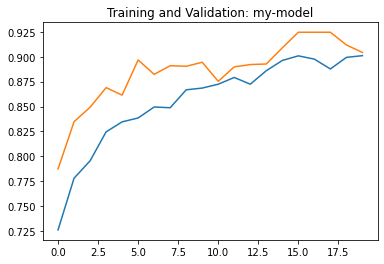

In [0]:
plot_training(history1,'my-model')

In [0]:
history2=finetune_model.fit_generator(train_data,epochs=epochs,validation_data=test_data,verbose=1,steps_per_epoch=x_train.shape[0]//batch_size,callbacks=callback_list)

Epoch 1/20
323/323 [==============================] - 34s 105ms/step - loss: 2.3954 - accuracy: 0.8846 - val_loss: 8.3452 - val_accuracy: 0.1757

Epoch 00001: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 2/20
323/323 [==============================] - 32s 99ms/step - loss: 1.2307 - accuracy: 0.9374 - val_loss: 13.3792 - val_accuracy: 0.1525

Epoch 00002: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 3/20
323/323 [==============================] - 32s 99ms/step - loss: 0.7080 - accuracy: 0.9509 - val_loss: 8.6254 - val_accuracy: 0.1542

Epoch 00003: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 4/20
323/323 [==============================] - 32s 99ms/step - loss: 0.6919 - accuracy: 0.9517 - val_loss: 5.3835 - val_accuracy: 0.1525

Epoch 00004: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 5/20
323/323 [==============================] - 32s 99ms/step - loss: 0.5407 - accuracy: 0.9558 - val_loss: 6.9738 - val_accuracy: 0.152

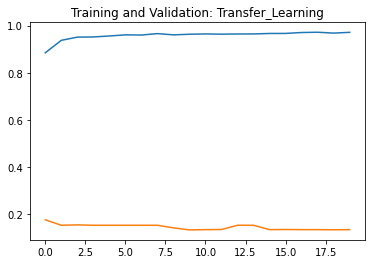

In [0]:
plot_training(history2,'Transfer_Learning')